<a href="https://colab.research.google.com/github/ryotaro1218/teiryoulast/blob/main/teiryoulast_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ITERATING ON KK

  metric    Kold      Knew
['0.5521', '10.0000', '4.4794']
['0.3771', '8.8959', '5.5410']
['0.1315', '8.2249', '7.1431']
['0.0205', '8.0085', '8.1730']
['0.0025', '8.0414', '8.0614']
['0.0015', '8.0454', '8.0337']
['0.0023', '8.0431', '8.0614']
['0.0031', '8.0467', '8.0219']
['0.0024', '8.0418', '8.0614']
['0.0091', '8.0457', '7.9724']
['0.0117', '8.0310', '8.1249']
['0.0083', '8.0498', '7.9828']
['0.0039', '8.0364', '8.0676']
['0.0005', '8.0426', '8.0386']


Text(0, 0.5, '% OF AGENTS')

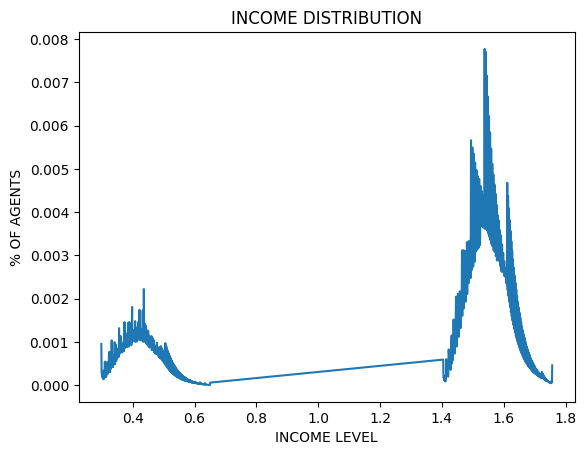

In [ ]:
import numpy as np
from scipy.stats import norm

def tauchen(n, mu, rho, sigma):
    # Function to implement Tauchen's method for discretizing a continuous state space
    # Inputs:
    # n: number of grid points
    # mu: mean of the AR(1) process
    # rho: AR(1) coefficient
    # sigma: standard deviation of the error term
    # Outputs:
    # transition_matrix: n x n transition matrix
    # state_space: n x 1 vector of state space points

    m = 1 / np.sqrt(1 - rho**2)

    # Compute the state space
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)

    # Compute the distance between grid points
    d = (state_space[n-1] - state_space[0]) / (n - 1)

    # Compute the transition probabilities
    transition_matrix = np.zeros((n, n))
    for i in range(n): # today state
        for j in range(n): # tomorrow state
            if j == 0: # prob going to the lower limit
                transition_matrix[i, j] = norm.cdf((state_space[0] - rho*state_space[i] + d/2) / sigma)
            elif j == n-1: # prob going to the upper limit
                transition_matrix[i, j] = 1 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2) / sigma)
            else:
                z_low = (state_space[j] - rho*state_space[i] - d/2) / sigma # the lower bound
                z_high = (state_space[j] - rho*state_space[i] + d/2) / sigma # the higher bound
                transition_matrix[i, j] = norm.cdf(z_high) - norm.cdf(z_low)

    return transition_matrix, state_space

import numpy as np

# function to comile parameters into one thing "parameter"
def setPar(
    sigma = 1.50, # risk aversion
    beta = 0.98, # subjective discount factor
    delta = 0.03, # depreciation
    alpha = 0.25, # capital’s share of income
    rho = 0.6, # labor productivity persistence
    a_l = 0, # lower bound of asset grids
    a_u = 20, # upper bound of asset grids
    NH = 2, # number of grids of h
    NA = 401, # number of grids of a
    ):

    # labor productivity variance.
    sigma_eps = np.sqrt(0.6*(1-rho**2))

    # making grids for ln h and solving for income transition probability using Tauchen's method.
    pi, h = tauchen(NH, -0.7, rho, sigma_eps)
    h = np.exp(h) # changing ln h grids to h grids

    # derive the stationary distribution from income transition process

    probst = np.ones((NH))/NH # setting the guess probability to a uniform distribution
    test = 10.0 # initialize the distance to a big number

    while test > 1e-8: # loop until convergence of the stationary distribution
        probst_new = np.zeros((NH)) # initialize new distribution
        for ih in range(NH): # today h
            for ihp in range(NH): # tomorrow h
                probst_new[ihp] += pi[ih, ihp]*probst[ih]

        test = np.max(np.abs(probst_new - probst)) # calculate the difference between the guess and the new distribution
        probst = probst_new # updating the guess

    HH = np.sum(h*probst) # aggregate effective labor

	  # create dictionary with parameters
    param = {}
    param['sigma'] = sigma; param['beta'] = beta; param['delta'] = delta;
    param['alpha'] = alpha; param['probst'] = probst;
    param['a_l'] = a_l; param['a_u'] = a_u; param['NH'] = NH; param['NA'] = NA;
    param['pi'] = pi; param['h'] = h; param['HH'] = HH;

    return param

def solve_household_gs(param, r, w):

    # opening the box of "param" to some parameters
    a_l = param['a_l']; a_u = param['a_u']; pi = param['pi']; delta = param['delta'];
    beta = param['beta']; sigma = param['sigma']; h = param['h']; NA = param['NA'];
    NH = param['NH'];

    # Create a grid of asset holdings
    a = np.linspace(a_l, a_u, NA)

    # Initialize the utility function to a large negative number for zero or negative consumption
    util = np.full((NA, NA, NH), -10000.0)

    # Calculate utility if the agent chooses asset a[iap] for each asset combination a[ia] and income shock h[ih]
    for ia in range(NA):
        for iap in range(NA):
            for ih in range(NH):
                cons = w*h[ih] + (1.0 + r)*a[ia] - a[iap]
                if cons > 0: # count only if consumption is positive
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)


    # Initialize some variables
    v = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus_new = np.full((NA, NH), -10000)
    iaplus = np.full((NA, NH), -10000)
    reward = np.zeros((NA, NA, NH))

    # Iterate on Bellman's equation and get the decision rules and the value function at the optimum
    test = 10
    while test != 0: # loop until policy function converges
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

        # Finding max of reward
        for ia in range(NA):
            for ih in range(NH):
                v_new[ia, ih] = np.max(reward[:, ia, ih]) # finding the maximal value
                iaplus_new[ia, ih] = np.argmax(reward[:, ia, ih]) # finding the index of the maximizer

        test = np.max(iaplus_new - iaplus) # stop if iaplus converges
        v = v_new
        iaplus = iaplus_new.copy()

    aplus = a[iaplus]

    # optimal consumption
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0 + r)*a[ia] - aplus[ia, ih]

    return aplus, iaplus, c

def get_distribution(param, decisions):

    a_l = param['a_l']; a_u = param['a_u']; pi = param['pi'];
    NA = param['NA']; NH = param['NH'];
    iaplus = decisions[1]

    # Generate a linearly spaced vector of NA values between a_l and a_u
    a = np.linspace(a_l, a_u, NA)

    test = 10 # Initialize a test value to be greater than 10^-8
    mu = np.ones((NA, NH)) / NA / NH # Initialize the distribution mu to be uniform

    # Loop until the test value is less than 10^-8
    while test > 1e-8:
        mu_new = np.zeros((NA, NH)) # Initialize a new distribution mu_new to be all zeros
        # Loop over all values of a, h, and h'
        for ia in range(NA):
            for ih in range(NH):
                for ihp in range(NH):
                    # Update mu_new using the interpolation indices, blending coefficients, and probabilities
                    mu_new[iaplus[ia, ih], ihp] += pi[ih, ihp] * mu[ia, ih]
        test = np.max(np.abs(mu_new - mu)) # Calculate the maximum difference between mu_new and mu
        mu = mu_new # Update mu to be mu_new

    return mu

def model_solution(param):

    alpha = param['alpha']
    delta = param['delta']
    HH = param['HH']

    phi = 0.2 # updating share
    toler = 1e-3 # warning: this doens't converge if tolerance is too small
    test = 10 # initial difference
    KK = 10.0 # initial capital

    print('ITERATING ON KK')
    print('')
    print('  metric    Kold      Knew')

    while test > toler:

        # Step 1
        # calculate rental rate of capital and w from firm FOC

        w = (1-alpha) * KK**(alpha) * HH**(-alpha)
        r = (alpha) * KK**(alpha-1) * HH**(1-alpha) - delta

        ####################################################
        # Step 2: Solving for households optimization (policy function of assets)
        ####################################################

        decisions = solve_household_gs(param, r, w)

        aplus = decisions[0] # note that the first component (index 0) of decisions is defines as aplus

        ####################################################
        # Step 3: Loop for finding eq distribution and capital
        ####################################################

        # eq distribution

        mu = get_distribution(param, decisions)

        # new aggregate capital

        KK_new = np.sum(mu*aplus)

        ####################################################
        # Loop for finding eq capital
        ####################################################

        # form metric and update KK

        test = abs((KK_new - KK)/KK) # loop until K converges
        print(['{:.4f}'.format(test), '{:.4f}'.format(KK), '{:.4f}'.format(KK_new)])
        KK = phi*KK_new + (1-phi)*KK # update K

    return decisions, r, w, KK, HH, mu

import matplotlib.pyplot as plt

param = setPar()
(decisions, r, w, KK, HH, mu) = model_solution(param)

h = param['h']
a_l = param['a_l']; a_u = param['a_u']; NA = param['NA'];
a = np.linspace(a_l, a_u, NA)


# calculate income distribution for each grid
income = np.array([(r*a + w*h[0]), (r*a + w*h[1])])
# # transpose income
income = income.T
# # sorting the income after flattening "income"
# pinc, index = np.sort(income.flatten('F')), np.argsort(income.flatten('F'))
# plambda = mu.flatten('F')
# #

# sort with regard to the 1st argument of zip
zip_lists = zip(income.flatten('F'), mu.flatten('F'))
# sort upwards
zip_sort = sorted(zip_lists)
# unzip
pinc, pmu = zip(*zip_sort)

plt.plot(pinc, pmu)
plt.title('INCOME DISTRIBUTION')
plt.xlabel('INCOME LEVEL')
plt.ylabel('% OF AGENTS')

ITERATING ON KK

  metric    Kold      Knew
['0.5521', '10.0000', '4.4794']
['0.3771', '8.8959', '5.5410']
['0.1315', '8.2249', '7.1431']
['0.0205', '8.0085', '8.1730']
['0.0025', '8.0414', '8.0614']
['0.0015', '8.0454', '8.0337']
['0.0023', '8.0431', '8.0614']
['0.0031', '8.0467', '8.0219']
['0.0024', '8.0418', '8.0614']
['0.0091', '8.0457', '7.9724']
['0.0117', '8.0310', '8.1249']
['0.0083', '8.0498', '7.9828']
['0.0039', '8.0364', '8.0676']
['0.0005', '8.0426', '8.0386']


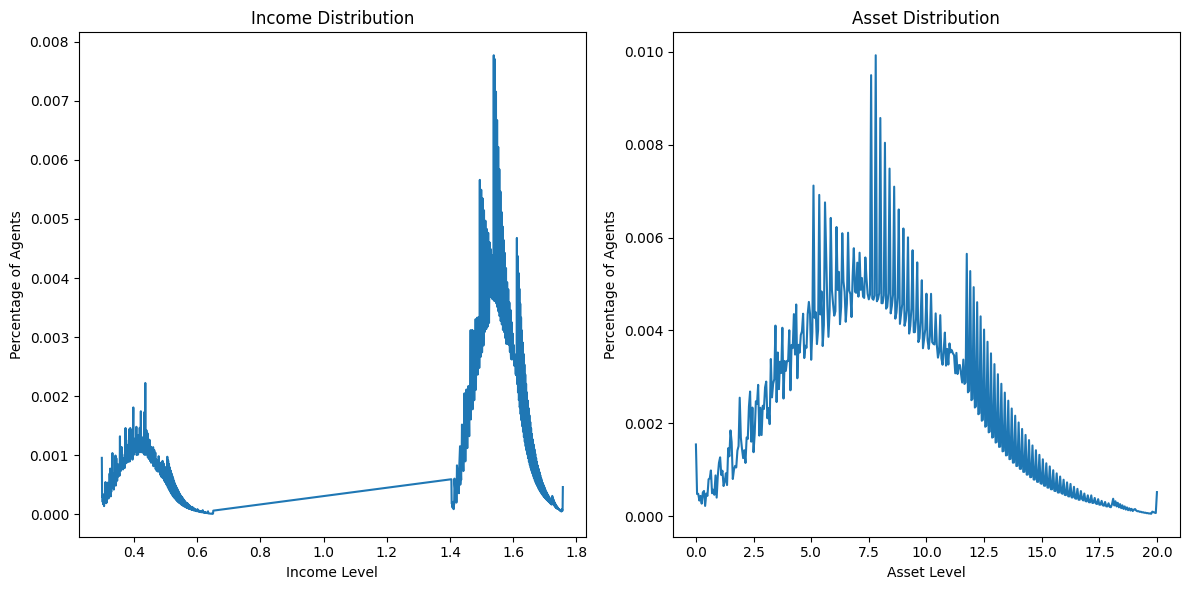

In [ ]:
# 問2: τ[k]=0%の場合の定常状態均衡

# パラメータの値
sigma = 1.50
beta = 0.98
delta = 0.03
alpha = 0.25
rho = 0.6
a_l = 0
a_u = 20
NH = 2
NA = 401

# モデルの設定
param = setPar(sigma=sigma, beta=beta, delta=delta, alpha=alpha, rho=rho, a_l=a_l, a_u=a_u, NH=NH, NA=NA)
(decisions, r, w, KK, HH, mu) = model_solution(param)

# グリッドを取得
h = param['h']
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a = np.linspace(a_l, a_u, NA)

# 所得と資産の分布を計算
income = np.array([(r * a + w * h[0]), (r * a + w * h[1])])
income = income.T
zip_lists = zip(income.flatten('F'), mu.flatten('F'))
zip_sort = sorted(zip_lists)
pinc, pmu = zip(*zip_sort)

# グラフを描画
plt.figure(figsize=(12, 6))

# 所得分布の図を描画
plt.subplot(1, 2, 1)
plt.plot(pinc, pmu)
plt.title('Income Distribution')
plt.xlabel('Income Level')
plt.ylabel('Percentage of Agents')

# 資産分布の図を描画
plt.subplot(1, 2, 2)
plt.plot(a, mu.sum(axis=1))
plt.title('Asset Distribution')
plt.xlabel('Asset Level')
plt.ylabel('Percentage of Agents')

plt.tight_layout()
plt.show()


In [ ]:
KK

8.041822600504139

In [ ]:
w

1.3033754232108015

In [ ]:
r

0.017633798605864934

ITERATING ON KK

  metric    Kold      Knew
['0.5521', '10.0000', '4.4794']
['0.3771', '8.8959', '5.5410']
['0.1315', '8.2249', '7.1431']
['0.0205', '8.0085', '8.1730']
['0.0025', '8.0414', '8.0614']
ITERATING ON KK

  metric    Kold      Knew
['0.8569', '10.0000', '1.4309']
['0.8212', '8.2862', '1.4819']
['0.7719', '6.9253', '1.5793']
['0.7087', '5.8561', '1.7058']
['0.6247', '5.0261', '1.8863']
['0.5133', '4.3981', '2.1406']
['0.3772', '3.9466', '2.4581']
['0.2114', '3.6489', '2.8774']
['0.0826', '3.4946', '3.2061']
['0.0200', '3.4369', '3.3682']
['0.0019', '3.4232', '3.4167']


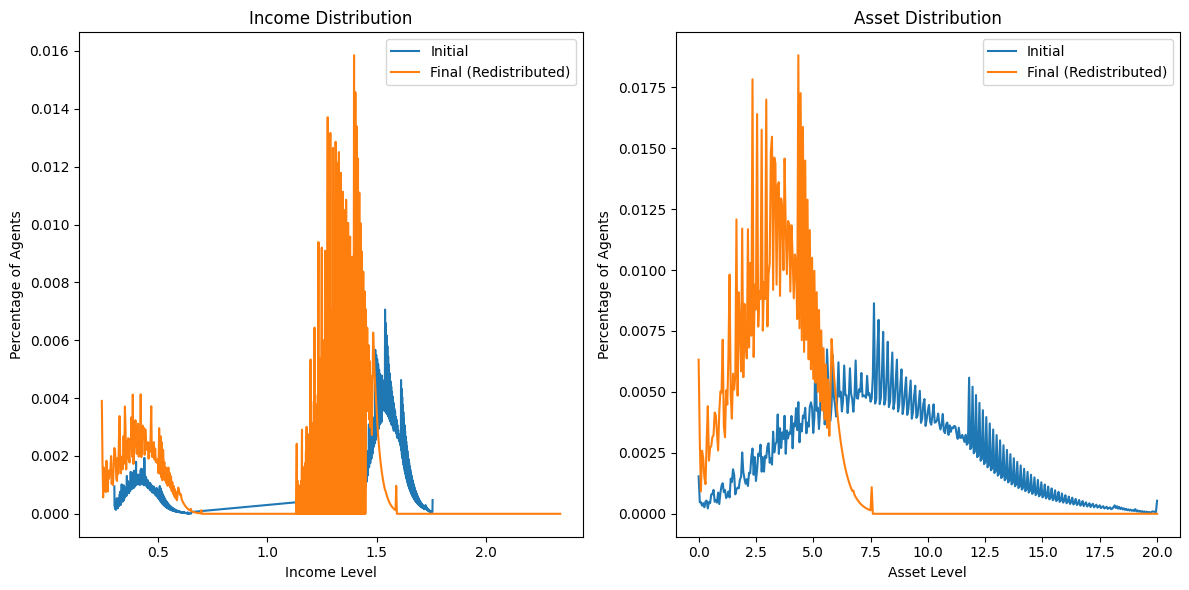

ITERATING ON KK

  metric    Kold      Knew
['0.8569', '10.0000', '1.4309']
['0.8212', '8.2862', '1.4819']
['0.7719', '6.9253', '1.5793']
['0.7087', '5.8561', '1.7058']
['0.6247', '5.0261', '1.8863']
['0.5133', '4.3981', '2.1406']
['0.3772', '3.9466', '2.4581']
['0.2114', '3.6489', '2.8774']
['0.0826', '3.4946', '3.2061']
['0.0200', '3.4369', '3.3682']
['0.0019', '3.4232', '3.4167']
所得格差の変化 (Gini係数の変化, 再分配後): -0.0018
GDPの変化率 (再分配後): -19.75%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def solve_household_gs(param, r, w, tau_k=0.0):
    # 修正: 資本所得税tau_kの導入
     # opening the box of "param" to some parameters
    a_l = param['a_l']; a_u = param['a_u']; pi = param['pi']; delta = param['delta'];
    beta = param['beta']; sigma = param['sigma']; h = param['h']; NA = param['NA'];
    NH = param['NH'];

    # Create a grid of asset holdings
    a = np.linspace(a_l, a_u, NA)

    # Initialize the utility function to a large negative number for zero or negative consumption
    util = np.full((NA, NA, NH), -10000.0)

    # Calculate utility if the agent chooses asset a[iap] for each asset combination a[ia] and income shock h[ih]
    for ia in range(NA):
        for iap in range(NA):
            for ih in range(NH):
                cons = w * h[ih] + (1.0 + r - tau_k) * a[ia] - a[iap] # 修正: 資本所得税tau_kの適用
                if cons > 0: # count only if consumption is positive
                    util[iap, ia, ih] = cons**(1.0 - sigma) / (1.0 - sigma)

    # Initialize some variables
    v = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus_new = np.full((NA, NH), -10000)
    iaplus = np.full((NA, NH), -10000)
    reward = np.zeros((NA, NA, NH))

    # Iterate on Bellman's equation and get the decision rules and the value function at the optimum
    test = 10
    while test != 0: # loop until policy function converges
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

        # Finding max of reward
        for ia in range(NA):
            for ih in range(NH):
                v_new[ia, ih] = np.max(reward[:, ia, ih]) # finding the maximal value
                iaplus_new[ia, ih] = np.argmax(reward[:, ia, ih]) # finding the index of the maximizer

        test = np.max(iaplus_new - iaplus) # stop if iaplus converges
        v = v_new
        iaplus = iaplus_new.copy()

    aplus = a[iaplus]

    # optimal consumption
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0 + r)*a[ia] - aplus[ia, ih]

    return aplus, iaplus, c

def model_solution(param, tau_k=0.0):
    # 修正: 資本所得税tau_kの導入

    alpha = param['alpha']
    delta = param['delta']
    HH = param['HH']

    phi = 0.2 # updating share
    toler = 1e-2 # warning: this doens't converge if tolerance is too small
    test = 10 # initial difference
    KK = 10.0 # initial capital

    print('ITERATING ON KK')
    print('')
    print('  metric    Kold      Knew')

    while test > toler:

        # Step 1
        # Calculate rental rate of capital and w from firm FOC
        w = (1 - alpha) * KK**alpha * HH**(-alpha)
        r = (alpha) * KK**(alpha - 1) * HH**(1 - alpha) - delta

        ####################################################
        # Step 2: Solving for households optimization (policy function of assets)
        ####################################################

        decisions = solve_household_gs(param, r, w, tau_k=tau_k)  # 修正: 資本所得税tau_kの適用
        aplus = decisions[0]  # note that the first component (index 0) of decisions is defined as aplus

        ####################################################
        # Step 3: Loop for finding eq distribution and capital
        ####################################################

        # eq distribution

        mu = get_distribution(param, decisions)

        # new aggregate capital

        KK_new = np.sum(mu*aplus)

        ####################################################
        # Loop for finding eq capital
        ####################################################

        # form metric and update KK

        test = abs((KK_new - KK)/KK) # loop until K converges
        print(['{:.4f}'.format(test), '{:.4f}'.format(KK), '{:.4f}'.format(KK_new)])
        KK = phi*KK_new + (1-phi)*KK # update K

    return decisions, r, w, KK, HH, mu


def calculate_redistribution(param, decisions, tau_k_initial, tau_k_final):
    # Calculate initial and final distributions of income and assets
    param['tau_k'] = tau_k_initial
    (decisions_initial, _, _, _, _, mu_initial) = model_solution(param, tau_k=tau_k_initial)

    param['tau_k'] = tau_k_final
    (decisions_final, _, _, _, _, mu_final) = model_solution(param, tau_k=tau_k_final)

    # Calculate tax revenue change
    tax_revenue_change = tau_k_final * (w * HH + decisions_final[1] * decisions_final[0]).sum() - \
                         tau_k_initial * (w * HH + decisions_initial[1] * decisions_initial[0]).sum()

    # Calculate redistribution per capita
    num_households = mu_initial.size
    redistribution_per_capita = tax_revenue_change / num_households

    # Calculate new distribution after redistribution
    mu_final_redistributed = mu_final + redistribution_per_capita

    # Normalize to ensure it sums to 1
    mu_final_redistributed /= mu_final_redistributed.sum()

    return mu_final_redistributed

# 問3: 資本所得税増加実験の影響

# パラメータの値
tau_k_initial = 0.0
tau_k_final = 0.05

# モデルの設定（初期の資本所得税率で計算）
param = setPar(sigma=sigma, beta=beta, delta=delta, alpha=alpha, rho=rho, a_l=a_l, a_u=a_u, NH=NH, NA=NA)
(decisions, r, w, KK, HH, mu) = model_solution(param, tau_k=tau_k_initial)

# 初期の定常状態での所得と資産の分布を計算
income_initial = np.array([(r * a + w * h[0]), (r * a + w * h[1])])
income_initial = income_initial.T
zip_lists_initial = zip(income_initial.flatten('F'), mu.flatten('F'))
zip_sort_initial = sorted(zip_lists_initial)
pinc_initial, pmu_initial = zip(*zip_sort_initial)

# モデルの設定（増加後の資本所得税率で計算）
param['tau_k'] = tau_k_final
(decisions_final, r, w, KK_final, HH, mu_final_redistributed) = model_solution(param, tau_k=tau_k_final)

# 増加後の定常状態での所得と資産の分布を計算
income_final = np.array([(r * a + w * h[0]), (r * a + w * h[1])])
income_final = income_final.T
zip_lists_final = zip(income_final.flatten('F'), mu_final_redistributed.flatten('F'))
zip_sort_final = sorted(zip_lists_final)
pinc_final, pmu_final_redistributed = zip(*zip_sort_final)


# グラフを描画
plt.figure(figsize=(12, 6))

# 所得分布の図を描画
plt.subplot(1, 2, 1)
plt.plot(pinc_initial, pmu_initial, label='Initial')
plt.plot(pinc_final, pmu_final_redistributed, label='Final (Redistributed)')
plt.title('Income Distribution')
plt.xlabel('Income Level')
plt.ylabel('Percentage of Agents')
plt.legend()

# 資産分布の図を描画
plt.subplot(1, 2, 2)
plt.plot(a, mu.sum(axis=1), label='Initial')
plt.plot(a, mu_final_redistributed.sum(axis=1), label='Final (Redistributed)')
plt.title('Asset Distribution')
plt.xlabel('Asset Level')
plt.ylabel('Percentage of Agents')
plt.legend()

plt.tight_layout()
plt.show()

def calculate_gini_coefficient(pinc, pmu):
    # ローレンツ曲線の面積を計算
    total_area = np.trapz(pmu, pinc)

    # 均等分配線の下の面積を計算
    equal_distribution_area = 0.5  # 均等分配線は y = x なので、この直線より下の面積は0.5

    # Gini係数の計算
    gini_coefficient = (equal_distribution_area - total_area) / equal_distribution_area

    return gini_coefficient

# 初期の所得格差の計算
gini_initial = calculate_gini_coefficient(pinc_initial, pmu_initial)

# 増加後の所得格差の計算
gini_final_redistributed = calculate_gini_coefficient(pinc_final, pmu_final_redistributed)

# 所得格差の変化を計算
gini_change_redistributed = gini_final_redistributed - gini_initial



# GDPの変化を計算
initial_GDP = w * HH + r * KK
param['tau_k'] = tau_k_final
(decisions, r, w, KK_final, HH, mu) = model_solution(param, tau_k=tau_k_final)
final_GDP_redistributed = w * HH + r * KK_final
GDP_change_redistributed = (final_GDP_redistributed - initial_GDP) / initial_GDP * 100

# 結果を表示
print("所得格差の変化 (Gini係数の変化, 再分配後): {:.4f}".format(gini_change_redistributed))
print("GDPの変化率 (再分配後): {:.2f}%".format(GDP_change_redistributed))


In [ ]:
KK

8.045425204035851

In [ ]:
w

1.0527537274828012

In [ ]:
r

0.060394797341962556